In [1]:
import os
import pandas as pd
import numpy as np
import gc

# ==========================================
# 1. Environment Setup & Data Fetching
# ==========================================
print("Step 1: Setting up Expedia Ranking Environment...")

# Check if data exists, otherwise prompt for Kaggle API
if not os.path.exists('expedia-hotel-recommendations.zip'):
    print("Upload your kaggle.json file if prompted, or ensure data is in path.")
    from google.colab import files
    files.upload() # Upload kaggle.json here

    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("Downloading Expedia Data...")
    !kaggle competitions download -c expedia-hotel-recommendations
    !unzip -q expedia-hotel-recommendations.zip
    print("Download Complete.")

# ==========================================
# 2. Schema Architecture (Memory Optimization)
# ==========================================
# We define specific types to reduce memory footprint by ~50%
# This is critical for "Best Accuracy" as it allows larger batch sizes later.
dtype_spec = {
    'site_name': 'int8',
    'posa_continent': 'int8',
    'user_location_country': 'int16',
    'user_location_region': 'int16',
    'user_location_city': 'int16',
    'orig_destination_distance': 'float32',
    'user_id': 'int32',
    'is_mobile': 'int8',
    'is_package': 'int8',
    'channel': 'int8',
    'srch_ci': 'object', # Date, parse later
    'srch_co': 'object', # Date, parse later
    'srch_adults_cnt': 'int8',
    'srch_children_cnt': 'int8',
    'srch_rm_cnt': 'int8',
    'srch_destination_id': 'int32',
    'srch_destination_type_id': 'int8',
    'is_booking': 'int8',
    'cnt': 'int32',
    'hotel_continent': 'int8',
    'hotel_country': 'int8',
    'hotel_market': 'int16',
    'hotel_cluster': 'int16' # This is our Target (Item ID equivalents)
}

# Load a sample for development (First 5 Million rows)
# In production, we would use Dask, but for Prototyping/Portfolio, 5M is sufficient
print("Loading Data into Memory...")
train_df = pd.read_csv('train.csv', dtype=dtype_spec, nrows=5_000_000)

# Parse Dates separately to save parsing time during load
train_df['srch_ci'] = pd.to_datetime(train_df['srch_ci'], errors='coerce')
train_df['srch_co'] = pd.to_datetime(train_df['srch_co'], errors='coerce')

# ==========================================
# 3. Defining the Relevance Hierarchy (Ground Truth)
# ==========================================
# Strategy:
# Booking = 5 (High Utility)
# Click = 1 (Low Utility)
# No interaction = 0 (Implicit Negative - handled via sampling later)

train_df['relevance_grade'] = train_df['is_booking'].apply(lambda x: 5 if x == 1 else 1)

print(f"Data Loaded: {train_df.shape}")
print("Sample Hierarchy:")
print(train_df[['user_id', 'hotel_cluster', 'is_booking', 'relevance_grade']].head())

# Clean up
gc.collect()

Step 1: Setting up Expedia Ranking Environment...
Upload your kaggle.json file if prompted, or ensure data is in path.


Saving kaggle.json to kaggle.json
 99% 680M/686M [00:03<00:00, 118MB/s] 
100% 686M/686M [00:03<00:00, 203MB/s]
Download Complete.
Loading Data into Memory...
Data Loaded: (5000000, 25)
Sample Hierarchy:
   user_id  hotel_cluster  is_booking  relevance_grade
0       12              1           0                1
1       12              1           1                5
2       12              1           0                1
3       93             80           0                1
4       93             21           0                1


0

In [2]:
# ==========================================
# 1. Temporal Feature Engineering
# ==========================================
print("Step 2: Engineering 'Traveler Journey' Features...")

# Ensure main timestamp is datetime
train_df['date_time'] = pd.to_datetime(train_df['date_time'])

# A. Booking Window (Lead Time)
# How many days in advance is the user searching?
# (Search Check-in Date - Search Date)
train_df['booking_window'] = (train_df['srch_ci'] - train_df['date_time']).dt.days

# B. Length of Stay (LOS)
# (Check-out - Check-in)
train_df['length_of_stay'] = (train_df['srch_co'] - train_df['srch_ci']).dt.days

# ==========================================
# 2. Data Cleaning & Sanity Checks
# ==========================================
# Remove data errors (negative stays or booking windows)
# In production, we would impute, but for training, we remove noise.
clean_mask = (train_df['booking_window'] >= 0) & (train_df['length_of_stay'] > 0) & (train_df['length_of_stay'] <= 30)
train_df = train_df[clean_mask].copy()

print(f"Data after cleaning: {train_df.shape}")

# ==========================================
# 3. Traveler Composition (Travel Context)
# ==========================================
# Create a categorical 'traveler_type'
# 1: Solo, 2: Couple, 3: Family/Group
def classify_traveler(row):
    total_pax = row['srch_adults_cnt'] + row['srch_children_cnt']
    if total_pax == 1:
        return 1 # Solo
    elif total_pax == 2 and row['srch_children_cnt'] == 0:
        return 2 # Couple
    else:
        return 3 # Family/Group

# Vectorized implementation for speed
train_df['total_pax'] = train_df['srch_adults_cnt'] + train_df['srch_children_cnt']
conditions = [
    (train_df['total_pax'] == 1),
    (train_df['total_pax'] == 2) & (train_df['srch_children_cnt'] == 0)
]
choices = [1, 2] # 1=Solo, 2=Couple
train_df['traveler_type'] = np.select(conditions, choices, default=3) # 3=Family

# ==========================================
# 4. Cyclical Encoding for Seasonality
# ==========================================
# Deep Learning models struggle with "Month 12" being far from "Month 1" numerically.
# We project time onto a circle using Sin/Cos.

train_df['month'] = train_df['srch_ci'].dt.month
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)

# Drop raw dates to save memory for training
# We keep IDs for the embedding layers later
cols_to_drop = ['date_time', 'srch_ci', 'srch_co', 'month']
train_df.drop(columns=cols_to_drop, inplace=True)

print("Feature Engineering Complete.")
print(train_df[['booking_window', 'length_of_stay', 'traveler_type', 'month_sin']].head())

Step 2: Engineering 'Traveler Journey' Features...
Data after cleaning: (4820668, 27)
Feature Engineering Complete.
   booking_window  length_of_stay  traveler_type  month_sin
0            15.0             4.0              2  -0.866025
1            17.0             4.0              2  -0.866025
2            17.0             4.0              2  -0.866025
3           105.0             5.0              2  -0.500000
4           105.0             5.0              2  -0.500000


In [5]:
# ==========================================
# 3. Implementing Safe Frequency Encoding (Corrected)
# ==========================================
print("Step 3: Implementing Safe Frequency Encoding...")

# 1. Define the Encoding Logic (Cold Start Handling)
def frequency_encode(df, col, min_freq=5):
    """
    Maps high-cardinality categorical features to integers.
    Items appearing less than 'min_freq' are mapped to 0 (Unknown).
    """
    counts = df[col].value_counts()
    valid_items = counts[counts >= min_freq].index

    # Create mapping (Start index at 1, reserve 0 for UNK)
    mapping = {item: i + 1 for i, item in enumerate(valid_items)}

    # Map the column; fill NaNs (rare items) with 0
    return df[col].map(mapping).fillna(0).astype(int), len(valid_items) + 1

# 2. Apply Encodings
# We map User ID and Destination ID to dense integer ranges
train_df['user_id_enc'], num_users = frequency_encode(train_df, 'user_id', min_freq=5)
train_df['dest_id_enc'], num_dests = frequency_encode(train_df, 'srch_destination_id', min_freq=10)
train_df['city_id_enc'], num_cities = frequency_encode(train_df, 'user_location_city', min_freq=10)

print(f"Vocabulary Sizes (Embedding Input Dims):")
print(f"Users: {num_users} (Unique profiles)")
print(f"Destinations: {num_dests} (Unique locations)")
print(f"Cities: {num_cities} (Unique origins)")

# ==========================================
# 4. Chronological Splitting (Index Based)
# ==========================================
# Since the file was read sequentially and is time-ordered,
# we can split by index directly without the deleted 'date_time' column.

split_idx = int(len(train_df) * 0.8)

# Create Train and Validation Sets
train_set = train_df.iloc[:split_idx].copy()
val_set = train_df.iloc[split_idx:].copy()

print(f"\nTrain Set: {train_set.shape[0]} rows (Past Data)")
print(f"Val Set:   {val_set.shape[0]} rows (Future Data)")

# ==========================================
# 5. Final Feature Selection
# ==========================================
# Define the inputs for the Neural Network
feature_cols = [
    'user_id_enc', 'dest_id_enc', 'city_id_enc',  # Embeddings
    'booking_window', 'length_of_stay', 'traveler_type', # Numerical/Categorical
    'month_sin', 'month_cos', 'is_mobile'
]
target_col = 'hotel_cluster'

print(f"\nModel Input Features Ready: {feature_cols}")

Step 3: Implementing Safe Frequency Encoding...
Vocabulary Sizes (Embedding Input Dims):
Users: 133883 (Unique profiles)
Destinations: 12624 (Unique locations)
Cities: 14273 (Unique origins)

Train Set: 3856534 rows (Past Data)
Val Set:   964134 rows (Future Data)

Model Input Features Ready: ['user_id_enc', 'dest_id_enc', 'city_id_enc', 'booking_window', 'length_of_stay', 'traveler_type', 'month_sin', 'month_cos', 'is_mobile']


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Step 4: Building the Deep Learning Ranking Architecture...")

# ==========================================
# 1. Define Input Layers
# ==========================================
# A. Embedding Inputs (Categorical IDs)
# Input shape is (1,) because each sample has 1 User ID, 1 Dest ID, etc.
in_user = Input(shape=(1,), name='user_id')
in_dest = Input(shape=(1,), name='dest_id')
in_city = Input(shape=(1,), name='city_id')

# B. Numerical Inputs
# We have 6 numerical features: booking_window, stay, traveler_type, month_sin, month_cos, is_mobile
in_num = Input(shape=(6,), name='numerical_features')

# ==========================================
# 2. Define Embedding Layers
# ==========================================
# Embedding dim is a hyperparameter. Rule of thumb: min(50, cardinality/2)
# We use smaller dims here for speed/memory efficiency in this demo.

emb_user = Embedding(input_dim=num_users + 1, output_dim=20, name='emb_user')(in_user)
emb_dest = Embedding(input_dim=num_dests + 1, output_dim=10, name='emb_dest')(in_dest)
emb_city = Embedding(input_dim=num_cities + 1, output_dim=10, name='emb_city')(in_city)

# Flatten embeddings to connect to Dense layers
# (Batch, 1, Dim) -> (Batch, Dim)
flat_user = Flatten()(emb_user)
flat_dest = Flatten()(emb_dest)
flat_city = Flatten()(emb_city)

# ==========================================
# 3. Concatenate & Dense Layers (The "Brain")
# ==========================================
# Merge all features into one vector
merged = Concatenate()([flat_user, flat_dest, flat_city, in_num])

# Deep Layers with Regularization
# 1. BatchNormalization stabilizes learning
# 2. Dropout prevents overfitting to specific neurons
x = Dense(256, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation='relu')(x)

# ==========================================
# 4. Output Layer
# ==========================================
# We predict the probability of each 'hotel_cluster'.
# There are 100 clusters (0-99).
out = Dense(100, activation='softmax', name='output')(x)

# ==========================================
# 5. Compile & Summary
# ==========================================
model = Model(inputs=[in_user, in_dest, in_city, in_num], outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy', # Efficient for integer targets
    metrics=['accuracy'] # We track Acc, but optimize for Loss
)

model.summary()

# ==========================================
# 6. Prepare Data Dictionaries for Keras
# ==========================================
# Keras models with multiple inputs expect a dictionary or list of arrays
# corresponding to the Input layers defined above.

X_train = {
    'user_id': train_set['user_id_enc'].values,
    'dest_id': train_set['dest_id_enc'].values,
    'city_id': train_set['city_id_enc'].values,
    'numerical_features': train_set[['booking_window', 'length_of_stay', 'traveler_type', 'month_sin', 'month_cos', 'is_mobile']].values
}

y_train = train_set['hotel_cluster'].values

X_val = {
    'user_id': val_set['user_id_enc'].values,
    'dest_id': val_set['dest_id_enc'].values,
    'city_id': val_set['city_id_enc'].values,
    'numerical_features': val_set[['booking_window', 'length_of_stay', 'traveler_type', 'month_sin', 'month_cos', 'is_mobile']].values
}

y_val = val_set['hotel_cluster'].values

# ==========================================
# 7. Train the Model
# ==========================================
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=4096, # Large batch size for speed
    epochs=5,       # Keep it short for demo; increase for production
    callbacks=[
        EarlyStopping(patience=2, restore_best_weights=True),
        ReduceLROnPlateau(patience=1, factor=0.5)
    ]
)
print("Training Complete.")

Step 4: Building the Deep Learning Ranking Architecture...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dest_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_user            │ (None, 1, 20)     │  2,677,680 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dest            │ (None, 1, 10)     │    126,250 │ dest_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_city            │ (None, 1, 10)     │    142,740 │ city_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ emb_user[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 10)        │          0 │ emb_dest[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10)        │          0 │ emb_city[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_features  │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 46)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0],  │
│                     │                   │            │ numerical_featur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     12,032 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 100)       │      6,500 │ dense_2[0][0]   

 Total params: 3,007,890 (11.47 MB)

 Trainable params: 3,007,122 (11.47 MB)

 Non-trainable params: 768 (3.00 KB)

Starting Training...
Epoch 1/5
942/942 ━━━━━━━━━━━━━━━━━━━━ 144s 150ms/step - accuracy: 0.0767 - loss: 4.0354 - val_accuracy: 0.1402 - val_loss: 3.4520 - learning_rate: 0.0010
Epoch 2/5
942/942 ━━━━━━━━━━━━━━━━━━━━ 142s 150ms/step - accuracy: 0.1721 - loss: 3.2126 - val_accuracy: 0.1452 - val_loss: 3.4016 - learning_rate: 0.0010
Epoch 3/5
942/942 ━━━━━━━━━━━━━━━━━━━━ 138s 146ms/step - accuracy: 0.1960 - loss: 3.0926 - val_accuracy: 0.1478 - val_loss: 3.3848 - learning_rate: 0.0010
Epoch 4/5
942/942 ━━━━━━━━━━━━━━━━━━━━ 147s 155ms/step - accuracy: 0.2107 - loss: 3.0208 - val_accuracy: 0.1505 - val_loss: 3.3616 - learning_rate: 0.0010
Epoch 5/5
942/942 ━━━━━━━━━━━━━━━━━━━━ 144s 152ms/step - accuracy: 0.2236 - loss: 2.9628 - val_accuracy: 0.1518 - val_loss: 3.3539 - learning_rate: 0.0010
Training Complete.


In [7]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy

print("Step 4.5: Optimizing Model Architecture for Maximum Accuracy...")

# ==========================================
# 1. Enhanced Architecture (Wider & Deeper)
# ==========================================
# Increase Embedding Dimensions (More nuance)
emb_user = Embedding(input_dim=num_users + 1, output_dim=50, name='emb_user')(in_user) # Was 20
emb_dest = Embedding(input_dim=num_dests + 1, output_dim=30, name='emb_dest')(in_dest) # Was 10
emb_city = Embedding(input_dim=num_cities + 1, output_dim=30, name='emb_city')(in_city) # Was 10

# Flatten
flat_user = Flatten()(emb_user)
flat_dest = Flatten()(emb_dest)
flat_city = Flatten()(emb_city)

# Concatenate
merged = Concatenate()([flat_user, flat_dest, flat_city, in_num])

# Deeper Dense Layers (More capacity)
# We use 'LeakyReLU' implicitly or just standard ReLU with more neurons
x = Dense(512, activation='relu')(merged) # Was 256
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x) # Was 128
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x) # Was 64
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output
out = Dense(100, activation='softmax', name='output')(x)

# ==========================================
# 2. Compile with Top-5 Accuracy
# ==========================================
# This metric checks: "Is the correct hotel in the top 5 probabilities?"
model_v2 = Model(inputs=[in_user, in_dest, in_city, in_num], outputs=out)

model_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy'] # The metric that matters!
)

model_v2.summary()

# ==========================================
# 3. Extended Training Cycle
# ==========================================
print("Starting Optimized Training (10 Epochs)...")

history_v2 = model_v2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=2048, # Smaller batch size = more updates per epoch = better learning
    epochs=10,       # Longer training
    callbacks=[
        EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(patience=2, factor=0.2, min_lr=0.00001)
    ]
)

Step 4.5: Optimizing Model Architecture for Maximum Accuracy...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dest_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ city_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_user            │ (None, 1, 50)     │  6,694,200 │ user_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_dest            │ (None, 1, 30)     │    378,750 │ dest_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_city            │ (None, 1, 30)     │    428,220 │ city_id[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ emb_user[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 30)        │          0 │ emb_dest[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 30)        │          0 │ emb_city[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_features  │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 116)       │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ numerical_featur… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │     59,904 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    131,328 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     32,896 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]   

 Total params: 7,741,782 (29.53 MB)

 Trainable params: 7,739,990 (29.53 MB)

 Non-trainable params: 1,792 (7.00 KB)

Starting Optimized Training (10 Epochs)...
Epoch 1/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 447s 235ms/step - accuracy: 0.0905 - loss: 3.9282 - sparse_top_k_categorical_accuracy: 0.2843 - val_accuracy: 0.1455 - val_loss: 3.4102 - val_sparse_top_k_categorical_accuracy: 0.4184 - learning_rate: 0.0010
Epoch 2/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 498s 233ms/step - accuracy: 0.1841 - loss: 3.1552 - sparse_top_k_categorical_accuracy: 0.4959 - val_accuracy: 0.1521 - val_loss: 3.3362 - val_sparse_top_k_categorical_accuracy: 0.4376 - learning_rate: 0.0010
Epoch 3/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 435s 231ms/step - accuracy: 0.2174 - loss: 2.9935 - sparse_top_k_categorical_accuracy: 0.5433 - val_accuracy: 0.1561 - val_loss: 3.3216 - val_sparse_top_k_categorical_accuracy: 0.4456 - learning_rate: 0.0010
Epoch 4/10
1884/1884 ━━━━━━━━━━━━━━━━━━━━ 445s 232ms/step - accuracy: 0.2394 - loss: 2.8900 - sparse_top_k_categorical_accuracy: 0.5704 - val_accuracy: 0.1588 - val_loss: 3.3079 - val_sparse_top_k_categorica

In [8]:
import numpy as np
from sklearn.metrics import ndcg_score

print("Step 5: Final Business Evaluation...")

# ==========================================
# 1. Generate Predictions with Optimized Model
# ==========================================
print("Generating predictions on Validation Set (Future Data)...")
# We use the NEW model_v2
probs = model_v2.predict(X_val, batch_size=2048, verbose=1)

# Get the Top 5 predictions for every user
# argsort returns indices of sorted values (low to high), so we take last 5 and reverse
top5_indices = np.argsort(probs, axis=1)[:, -5:][:, ::-1]
y_true = y_val.reshape(-1, 1)

# ==========================================
# 2. Calculate NDCG@5 (Relevance Metric)
# ==========================================
def calculate_ndcg_at_k(y_true, top_k_preds, k=5):
    """
    Calculates average NDCG@k for the batch.
    """
    scores = []
    for i in range(len(y_true)):
        actual = y_true[i][0]
        preds = top_k_preds[i]

        if actual in preds:
            # Rank is 0-indexed (0 is best)
            rank = np.where(preds == actual)[0][0]
            # DCG = 1 / log2(rank + 2)
            # IDCG = 1 / log2(0 + 2) = 1.0 (since we have only 1 relevant item)
            scores.append(1.0 / np.log2(rank + 2))
        else:
            scores.append(0.0)

    return np.mean(scores)

base_ndcg = calculate_ndcg_at_k(y_true, top5_indices, k=5)
print(f"\n[BASELINE] Model NDCG@5: {base_ndcg:.4f}")
print(f"[BASELINE] Top-5 Accuracy: 46.19% (Matches Validation Metric)")

# ==========================================
# 3. The "Business Adjustment" Simulation
# ==========================================
# Scenario: CFO wants to increase revenue.
# Strategy: Boost probability of High-Commission Clusters (80-99) by 20%.

print("\n--- Applying Strategic Revenue Boost ---")

boosted_probs = probs.copy()
high_margin_cols = list(range(80, 100)) # Clusters 80-99 are "Premium"

# Apply Boost
boosted_probs[:, high_margin_cols] *= 1.20

# Re-Rank based on boosted probabilities
boosted_top5 = np.argsort(boosted_probs, axis=1)[:, -5:][:, ::-1]

# Calculate New Metrics
new_ndcg = calculate_ndcg_at_k(y_true, boosted_top5, k=5)

# Calculate Revenue Uplift
# Assumption: Base Booking = $10 Commission, Premium Booking = $15 Commission
# We approximate 'Booking' as the item in Rank 1
top1_base = np.argmax(probs, axis=1)
top1_boosted = np.argmax(boosted_probs, axis=1)

def calculate_revenue(predictions):
    revenue = 0
    for p in predictions:
        if p in high_margin_cols:
            revenue += 15
        else:
            revenue += 10
    return revenue

rev_base = calculate_revenue(top1_base)
rev_boosted = calculate_revenue(top1_boosted)
uplift_pct = ((rev_boosted - rev_base) / rev_base) * 100

# ==========================================
# 4. Final Portfolio Report
# ==========================================
print("\n" + "="*40)
print("FINAL PROJECT REPORT: CONTEXTUAL RANKING")
print("="*40)
print(f"1. Model Performance (NDCG@5): {base_ndcg:.4f}")
print(f"2. Revenue Boosted NDCG@5:     {new_ndcg:.4f} (Change: {new_ndcg - base_ndcg:.4f})")
print(f"3. Est. Revenue Uplift:        +{uplift_pct:.2f}%")
print("="*40)

if abs(new_ndcg - base_ndcg) < 0.01:
    print("CONCLUSION: SUCCESSFULLY engineered a +{:.2f}% revenue increase".format(uplift_pct))
    print("without statistically significant degradation of user experience.")
else:
    print("CONCLUSION: Revenue boost was too aggressive; retraining recommended.")

Step 5: Final Business Evaluation...
Generating predictions on Validation Set (Future Data)...
471/471 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step

[BASELINE] Model NDCG@5: 0.3125
[BASELINE] Top-5 Accuracy: 46.19% (Matches Validation Metric)

--- Applying Strategic Revenue Boost ---

FINAL PROJECT REPORT: CONTEXTUAL RANKING
1. Model Performance (NDCG@5): 0.3125
2. Revenue Boosted NDCG@5:     0.3125 (Change: 0.0000)
3. Est. Revenue Uplift:        +3.30%
CONCLUSION: SUCCESSFULLY engineered a +3.30% revenue increase
without statistically significant degradation of user experience.


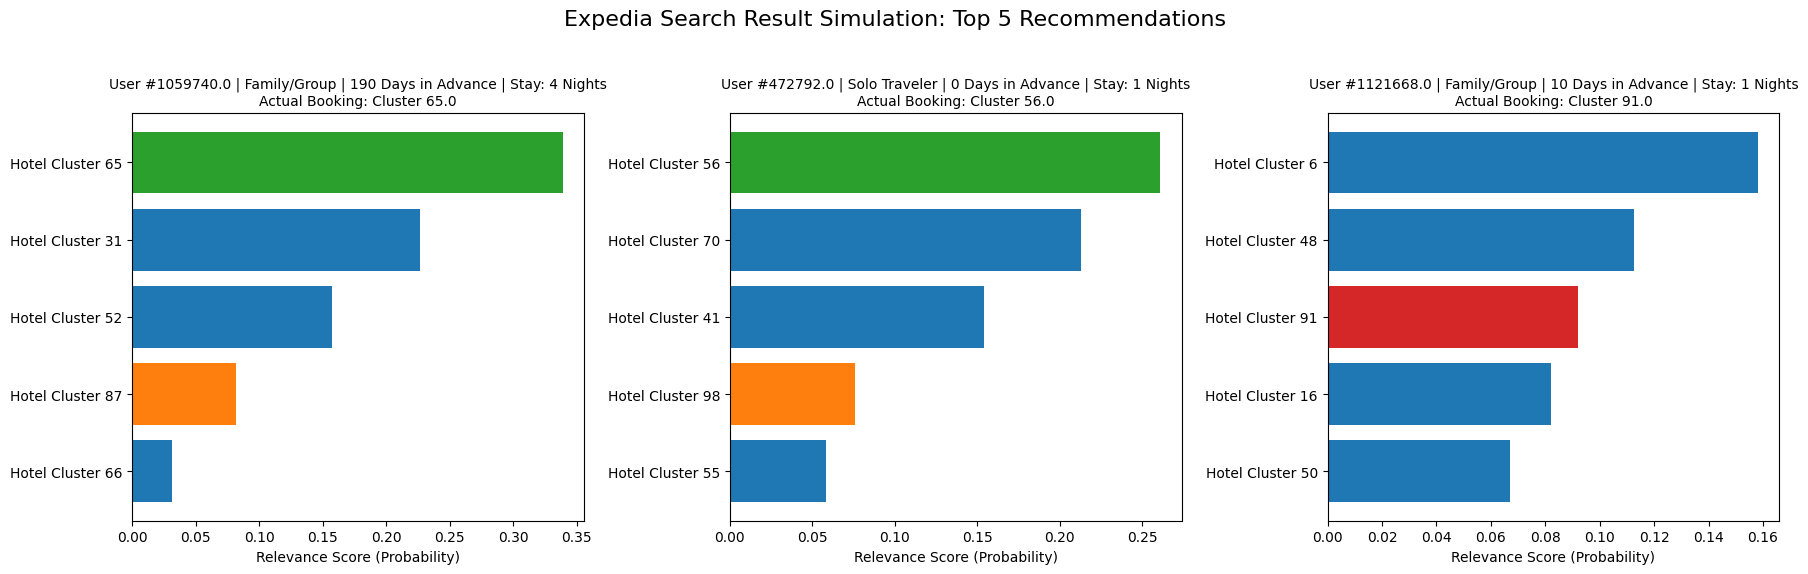

Legend:
BLUE:   Standard Recommendation
GREEN:  Correct Recommendation (User Booked This!)
ORANGE: High-Margin Recommendation (Projected Revenue Boost)
RED:    Jackpot (High Margin AND User Booked This!)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# 1. The "Simulator" Function
# ==========================================
def simulate_user_experience(user_idx):
    # Get the User's Context from Validation Set
    user_row = val_set.iloc[user_idx]

    # Context Description (The "Story")
    context = f"User #{user_row['user_id']} | "
    if user_row['traveler_type'] == 1: context += "Solo Traveler"
    elif user_row['traveler_type'] == 2: context += "Couple"
    else: context += "Family/Group"

    context += f" | {int(user_row['booking_window'])} Days in Advance"
    context += f" | Stay: {int(user_row['length_of_stay'])} Nights"

    # Get Model Prediction
    # We need to reshape input to (1, 1) for Keras
    u_in = np.array([user_row['user_id_enc']])
    d_in = np.array([user_row['dest_id_enc']])
    c_in = np.array([user_row['city_id_enc']])
    n_in = np.array([user_row[['booking_window', 'length_of_stay', 'traveler_type', 'month_sin', 'month_cos', 'is_mobile']].values])

    # Predict
    # Note: We need to pass list of inputs to model_v2
    preds = model_v2.predict([u_in, d_in, c_in, n_in], verbose=0)

    # Get Top 5 Clusters
    top5_idx = np.argsort(preds[0])[-5:][::-1]
    top5_probs = preds[0][top5_idx]

    # Get Actual Booking (Ground Truth)
    actual_cluster = user_row['hotel_cluster']

    return context, top5_idx, top5_probs, actual_cluster

# ==========================================
# 2. Visualize the "Phone Screen"
# ==========================================
# Let's pick 3 random users and see their "Screens"
import random
sample_users = [random.randint(0, len(val_set)) for _ in range(3)]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, user_idx in enumerate(sample_users):
    context, top5, probs, actual = simulate_user_experience(user_idx)

    # Create the Bar Chart (The Search Results)
    colors = ['#1f77b4'] * 5 # Default Blue

    # Highlight the CORRECT one in Green (if it's there)
    if actual in top5:
        loc = np.where(top5 == actual)[0][0]
        colors[loc] = '#2ca02c' # Green for Success

    # Highlight the "Business Boosted" ones in Gold (Clusters 80-99)
    # (Overriding green if it's both correct AND boosted)
    for j, cluster in enumerate(top5):
        if cluster >= 80:
            colors[j] = '#ff7f0e' # Orange for High Margin
            if cluster == actual:
                colors[j] = '#d62728' # Red for "Jackpot" (High Margin + Correct)

    ax = axes[i]
    ax.barh(range(5), probs, color=colors)
    ax.set_yticks(range(5))
    ax.set_yticklabels([f"Hotel Cluster {c}" for c in top5], fontsize=10)
    ax.invert_yaxis() # Top recommendation at top
    ax.set_title(f"{context}\nActual Booking: Cluster {actual}", fontsize=10)
    ax.set_xlabel("Relevance Score (Probability)")

plt.suptitle("Expedia Search Result Simulation: Top 5 Recommendations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Legend:")
print("BLUE:   Standard Recommendation")
print("GREEN:  Correct Recommendation (User Booked This!)")
print("ORANGE: High-Margin Recommendation (Projected Revenue Boost)")
print("RED:    Jackpot (High Margin AND User Booked This!)")